<a href="https://colab.research.google.com/github/marcinmichalsmolen/adam/blob/main/MGR17_TF_Flowers_CNN_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Zbiór TF Flowers - klasyfikacja za pomocą CNN oraz z wykorzystaniem pretrenowanej sieci VGG16

In [14]:
!nvidia-smi
## Import bibliotek
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

## Ładowanie obrazków i etykiet
(X_train, y_train), (X_test, y_test) = tfds.load(
    "tf_flowers",
    split=["train[:70%]", "train[:30%]"], ## Train test split
    batch_size=-1,
    as_supervised=True,
)

## Resizing obrazków
X_train = tf.image.resize(X_train, (150, 150))
X_test = tf.image.resize(X_test, (150, 150))

## Zmiana formatu etykiet 
y_train = to_categorical(y_train, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)

## Kopia danych na potrzeby kolejnych modeli
X_train2 = X_train
X_test2 = X_test
y_train2 = y_train
y_test2 = y_test

Sun Apr 23 10:13:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    30W /  70W |   9005MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Kształty naszych zbiorów danych i etykiet**

In [15]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2569, 150, 150, 3)
(1101, 150, 150, 3)
(2569, 5)
(1101, 5)


**Podgląd kilku obrazków z kwiatami (przed przeskalowaniem do kwadratowego kształtu 150x150px)**

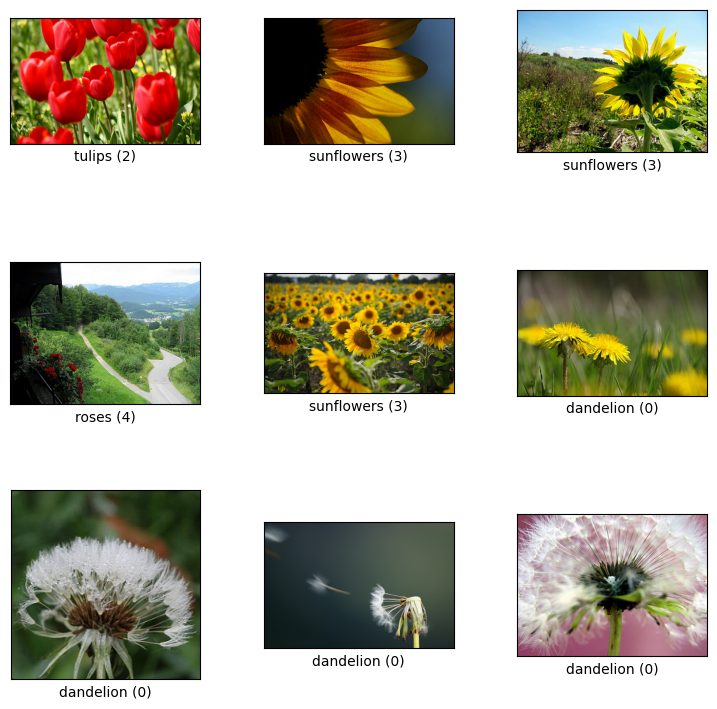

In [16]:
ds, ds_info = tfds.load('tf_flowers', split='train', with_info=True)
fig = tfds.show_examples(ds, ds_info)

In [26]:
def summarize_diagnostics(history):
  plt.title('Dokładność klasyfikacji - pomaranczowy train, zielony test')
  plt.plot(history.history['accuracy'], color='orange', label='train')
  plt.plot(history.history['val_accuracy'], color='green', label='test')
  plt.subplots_adjust (right=2)
  plt.show()

def summarize_diagnostics2(history):
  plt.title('Model loss - czerwony train, niebieski test')
  plt.plot(history.history['loss'], color='red', label='train')
  plt.plot(history.history['val_loss'], color='blue', label='test')
  plt.subplots_adjust (right=2)
  plt.show()

**Wczytawanie wytrenowanego modelu VGG16 do klasyfikacji obrazu.**

In [18]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

## Ładowanie modelu VGG16 bez ostatnich warstw 
base_model = VGG16(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
base_model.trainable = False ## Wagi nie będą trenowane

## Preprocessing input
X_train = preprocess_input(X_train) 
X_test = preprocess_input(X_test)

In [19]:
## Model VGG bez ostatnich warstw
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [20]:
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')


model1 = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_3 (Dense)             (None, 50)                409650    
                                                                 
 dense_4 (Dense)             (None, 20)                1020      
                                                                 
 dense_5 (Dense)             (None, 5)                 105       
                                                                 
Total params: 15,125,463
Trainable params: 410,775
Non-trainable params: 14,714,688
_________________________________________________________________


In [21]:
from tensorflow.keras.callbacks import EarlyStopping

model1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

**Trening modelu na swoich danych**

**Trening**

In [22]:
history1 = model1.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=32, callbacks=[es])

Epoch 1/50
65/65 [==============================] - 8s 88ms/step - loss: 1.8495 - accuracy: 0.4818 - val_loss: 1.0836 - val_accuracy: 0.5992
Epoch 2/50
65/65 [==============================] - 6s 88ms/step - loss: 0.7887 - accuracy: 0.7187 - val_loss: 0.9782 - val_accuracy: 0.6673
Epoch 3/50
65/65 [==============================] - 5s 83ms/step - loss: 0.5161 - accuracy: 0.8102 - val_loss: 0.9614 - val_accuracy: 0.6770
Epoch 4/50
65/65 [==============================] - 6s 88ms/step - loss: 0.3615 - accuracy: 0.8740 - val_loss: 0.9752 - val_accuracy: 0.6965
Epoch 5/50
65/65 [==============================] - 5s 84ms/step - loss: 0.2371 - accuracy: 0.9246 - val_loss: 0.9507 - val_accuracy: 0.7043
Epoch 6/50
65/65 [==============================] - 6s 85ms/step - loss: 0.1599 - accuracy: 0.9513 - val_loss: 1.0093 - val_accuracy: 0.7082
Epoch 7/50
65/65 [==============================] - 6s 88ms/step - loss: 0.1059 - accuracy: 0.9747 - val_loss: 1.0504 - val_accuracy: 0.7198
Epoch 8/50
65

**Ewaluacja**

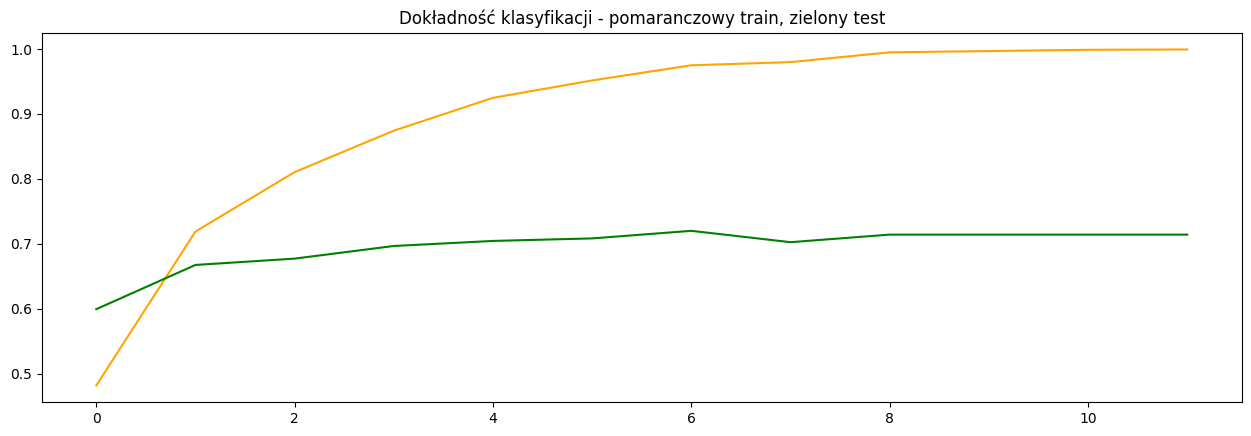

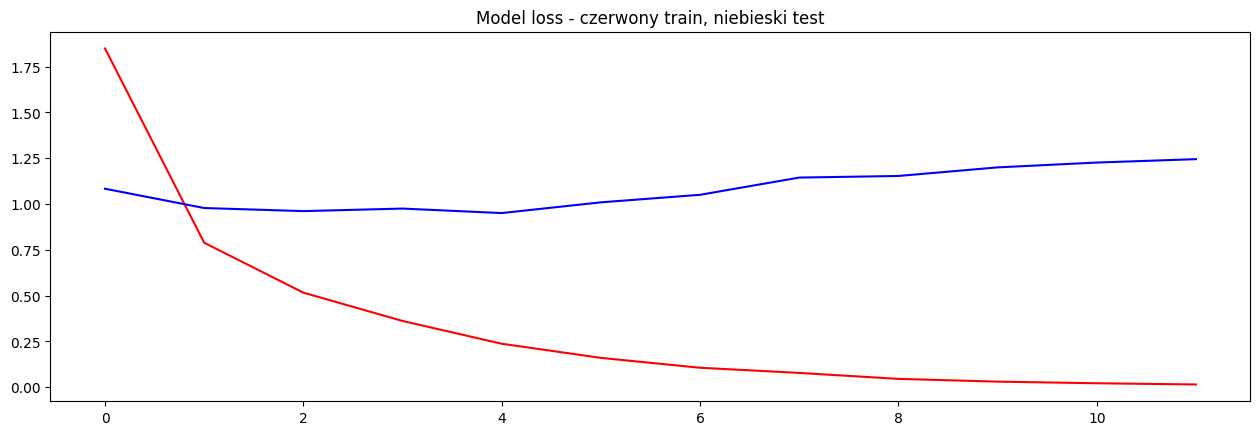

35/35 [==============================] - 2s 66ms/step - loss: 0.0745 - accuracy: 0.9873


[0.07446082681417465, 0.9872843027114868]

In [27]:
summarize_diagnostics(history1)
summarize_diagnostics2(history1)
model1.evaluate(X_train, y_train)
model1.evaluate(X_test, y_test)

**Omówienie eksperymentu i wyników**

Zbiór tf_flowers zawiera 3670 obrazków kwiatów w 5 kategoriach. Orginalnie obrazki mają kształty prostokątów - aby móc zastosować warstwy jak MaxPooling zostały przeskalowane do kształtu kwadratowego 150x150 pixeli. Zdjęcia przedstawiają kwiatu z różnej perspektywy i odległości. Sieć ma łącznie 15 125 463 parametrów, z których 14,714,688 nie było teraz trenowanych (początkowe warstwy modelu VGG16 oraz 410,775 parametry podlegające treningowi (w kolejnych warstwach dense (Dense) - 409650 oraz dense_1 (Dense) - 1020 oraz dense_2 - 105). Zbiór danych jest stosunkowo mały. Wytrenowane wcześniej przez twórców na dużym zbiorze danych warstwy VGG16 bardzo dobrze radzą sobie z ekstrakcją cech dla zbioru tf_flowers.

#Zastosowanie różnych modeli sieci CNN trenowanych "od zera" dla zbioru danych tf_flowers

**Sieć CNN bardziej złożona**

---





In [28]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dropout
from keras.layers import RandomZoom, RandomFlip
from keras.layers import BatchNormalization

In [29]:
model_max = Sequential([
    RandomFlip("horizontal", input_shape=(150, 150, 3)),
    RandomZoom(0.2, 0.2),

    Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.2),

    Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.2),

    Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.2),
    
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(5, activation='softmax')
])
model_max.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_max.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 150, 150, 3)       0         
                                                                 
 random_zoom (RandomZoom)    (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 150, 150, 32)     128       
 hNormalization)                                      

In [30]:
history2 = model_max.fit(X_train2, y_train2, epochs=50, batch_size=32, validation_split=0.2, callbacks=[es])

Epoch 1/50
65/65 [==============================] - 19s 141ms/step - loss: 1.7587 - accuracy: 0.2988 - val_loss: 1.6868 - val_accuracy: 0.2607
Epoch 2/50
65/65 [==============================] - 7s 114ms/step - loss: 1.3642 - accuracy: 0.4555 - val_loss: 2.8875 - val_accuracy: 0.3074
Epoch 3/50
65/65 [==============================] - 8s 120ms/step - loss: 1.3262 - accuracy: 0.4564 - val_loss: 2.7930 - val_accuracy: 0.3093
Epoch 4/50
65/65 [==============================] - 8s 120ms/step - loss: 1.1749 - accuracy: 0.5299 - val_loss: 2.3725 - val_accuracy: 0.3930
Epoch 5/50
65/65 [==============================] - 7s 115ms/step - loss: 1.1198 - accuracy: 0.5577 - val_loss: 1.4893 - val_accuracy: 0.4922
Epoch 6/50
65/65 [==============================] - 8s 120ms/step - loss: 1.0256 - accuracy: 0.6010 - val_loss: 3.1873 - val_accuracy: 0.3930
Epoch 7/50
65/65 [==============================] - 8s 120ms/step - loss: 0.9560 - accuracy: 0.6263 - val_loss: 1.2134 - val_accuracy: 0.5350
Epoch

**Ewaluacja**

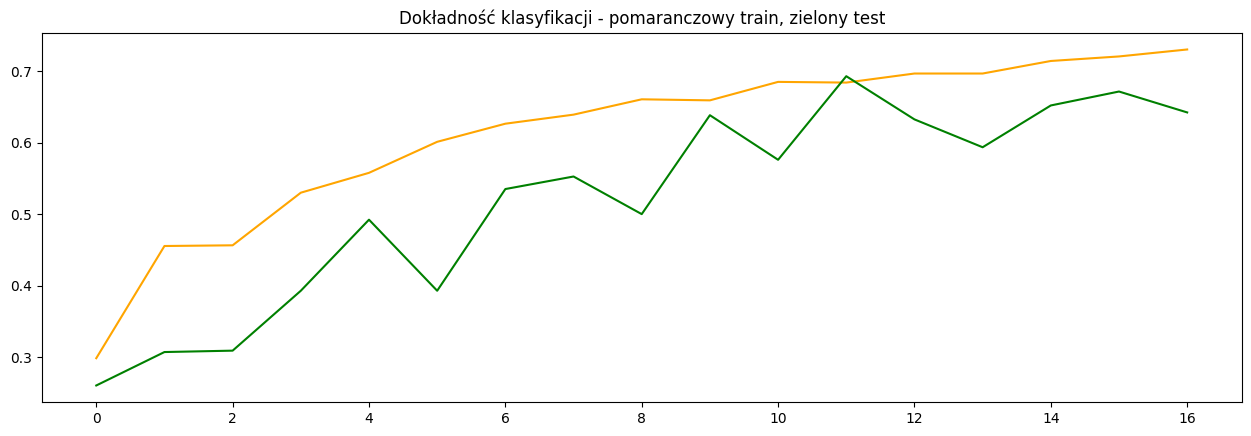

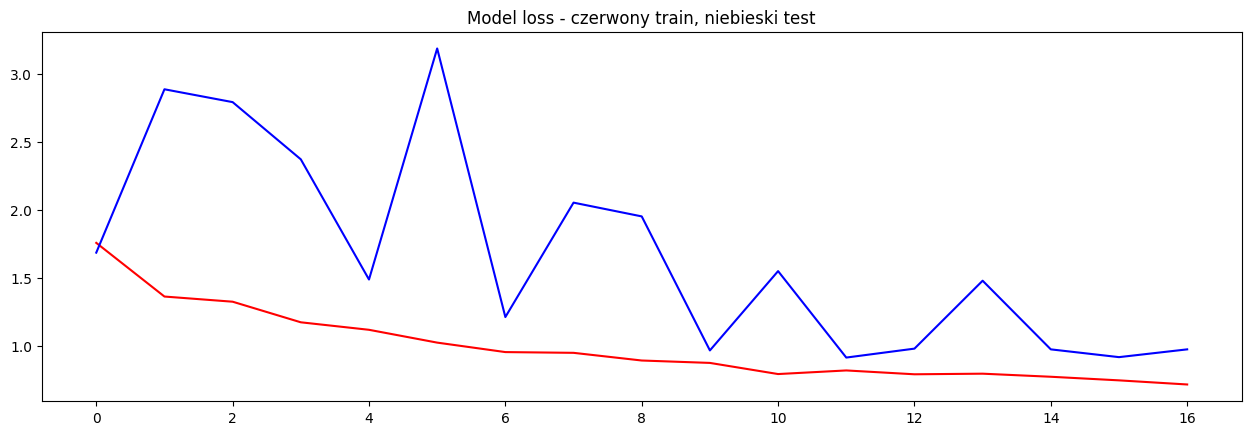

35/35 [==============================] - 1s 32ms/step - loss: 0.7318 - accuracy: 0.7330


[0.7318020462989807, 0.7329699993133545]

In [31]:
summarize_diagnostics(history2)
summarize_diagnostics2(history2)
model_max.evaluate(X_train2, y_train2)
model_max.evaluate(X_test2, y_test2)

**Omówienie eksperymentu i wyników**
W poprzednim przypadku dzięki wykorzystaniu wytrenowanego modelu VGG16 czas potrzebny do uzyskania zadowalających wyników jest bardzo krótki. Trening sieci "od zera" jest bardziej czasochłonny a przy tak małej liczebności zbioru ciężko zbliżyć się do wyników z zastosowaniem VGG16.

**Prosty CNN**

In [32]:
model3 = Sequential([
    Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')
])
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 41472)             0         
                                                                 
 dense_8 (Dense)             (None, 128)              

In [33]:
history3 = model3.fit(X_train2, y_train2, epochs=50, batch_size=32, validation_split=0.2, callbacks=[es])

Epoch 1/50
65/65 [==============================] - 4s 29ms/step - loss: 26.3502 - accuracy: 0.2900 - val_loss: 1.5136 - val_accuracy: 0.3463
Epoch 2/50
65/65 [==============================] - 1s 18ms/step - loss: 1.2173 - accuracy: 0.5192 - val_loss: 1.4112 - val_accuracy: 0.4008
Epoch 3/50
65/65 [==============================] - 1s 19ms/step - loss: 0.7785 - accuracy: 0.7080 - val_loss: 1.6916 - val_accuracy: 0.4377
Epoch 4/50
65/65 [==============================] - 1s 19ms/step - loss: 0.5262 - accuracy: 0.8248 - val_loss: 2.2009 - val_accuracy: 0.4086
Epoch 5/50
65/65 [==============================] - 1s 19ms/step - loss: 0.2747 - accuracy: 0.9134 - val_loss: 2.3588 - val_accuracy: 0.4300
Epoch 6/50
65/65 [==============================] - 1s 18ms/step - loss: 0.1888 - accuracy: 0.9460 - val_loss: 2.2178 - val_accuracy: 0.4397
Epoch 7/50
65/65 [==============================] - 1s 19ms/step - loss: 0.2844 - accuracy: 0.9095 - val_loss: 2.9251 - val_accuracy: 0.4475
Epoch 8/50
6

**Ewaluacja**

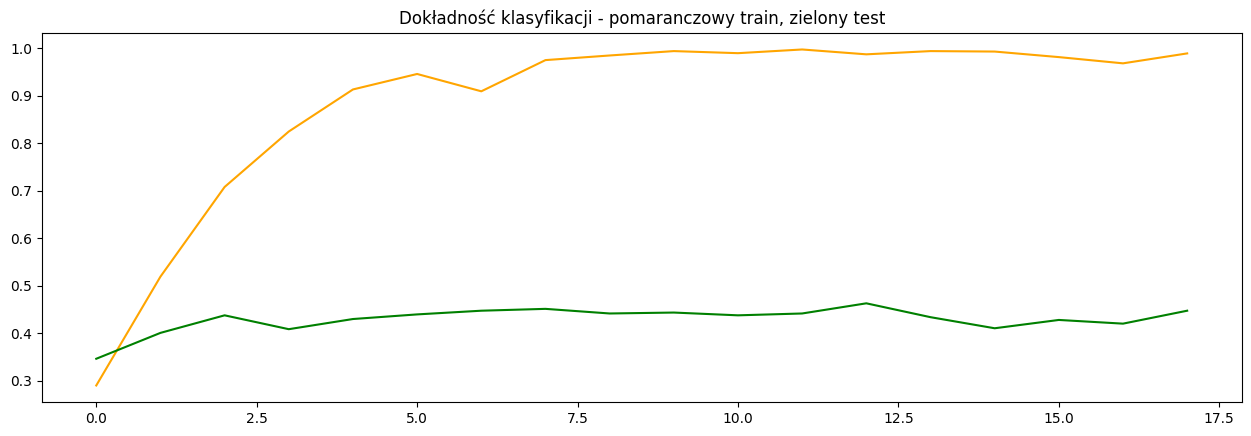

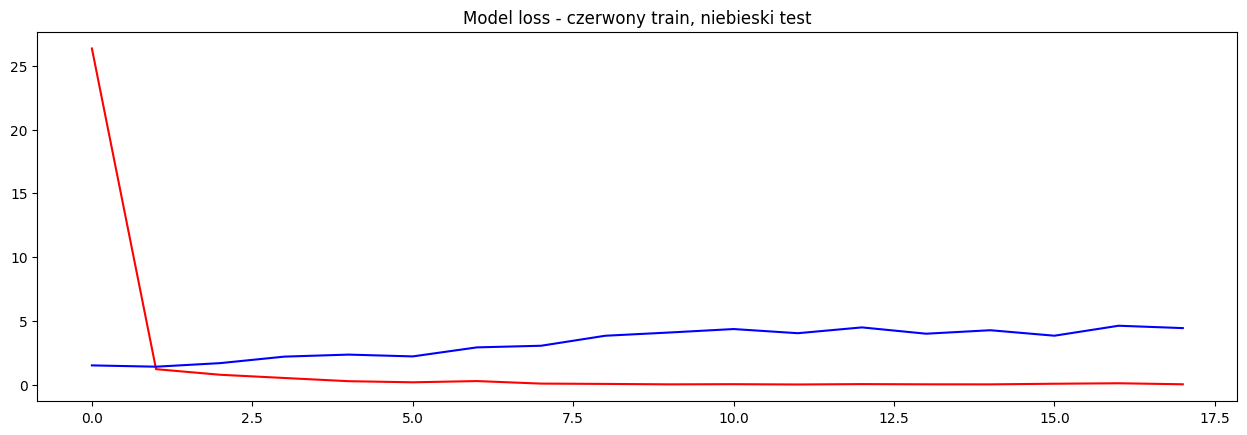

35/35 [==============================] - 0s 11ms/step - loss: 0.0231 - accuracy: 0.9955


[0.023096518591046333, 0.9954586625099182]

In [34]:
summarize_diagnostics(history3)
summarize_diagnostics2(history3)
model3.evaluate(X_train2, y_train2)
model3.evaluate(X_test2, y_test2)